# Converting CT scans to 3D models

Importing libraries (Half of them are redundant as I was just experimenting.)

In [ ]:
import nibabel as nib
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import os
from skimage import measure
from scipy.ndimage import  binary_erosion, binary_dilation, binary_fill_holes
from skimage.measure import label, regionprops
from skimage.morphology import binary_closing, remove_small_objects, disk, closing, opening, ball
from skimage.filters import sobel
from skimage.feature import canny
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import plotly.graph_objects as go

## Loading the data

Connecting to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load original data **(Do not run)**

In [ ]:
file1 = '/content/drive/MyDrive/Lungs_visualization_and_LLM_project/CTto3D/train_1_a_1.nii'
img1 = nib.load(file1)

print(f"Size of {file1}: {os.path.getsize(file1) / (1024*1024):.2f} MB")
print(f"Shape of {file1}: {img1.shape}")

Size of /content/drive/MyDrive/Lungs_visualization_and_LLM_project/CTto3D/train_1_a_1.nii: 606.00 MB
Shape of /content/drive/MyDrive/Lungs_visualization_and_LLM_project/CTto3D/train_1_a_1.nii: (512, 512, 303)


In [ ]:
print(img1.header)

convet float64 to float32 (reduce size by half while retaining most of the data)**(Do not run)**

In [ ]:
compressed_data = data.astype(np.float32)

compressed_nii = nib.Nifti1Image(compressed_data, affine=img1.affine, header=img1.header)
compressed_nii.header.set_data_dtype(np.float32)
compressed_path = "/content/drive/MyDrive/Lungs_visualization_and_LLM_project/CTto3D/train_1_a_1_compressed.nii"
nib.save(compressed_nii, compressed_path)

Load the new compressed dataset

In [ ]:
compressed_path = "/content/drive/MyDrive/Lungs_visualization_and_LLM_project/CTto3D/train_1_a_1_compressed.nii"
print(f"Size of {compressed_path}: {os.path.getsize(compressed_path) / (1024*1024):.2f} MB")

Size of /content/drive/MyDrive/Lungs_visualization_and_LLM_project/CTto3D/train_1_a_1_compressed.nii: 303.00 MB


In [ ]:
img1 = nib.load(compressed_path)

print(f"Shape of {compressed_path}: {img1.shape}")

Shape of /content/drive/MyDrive/Lungs_visualization_and_LLM_project/CTto3D/train_1_a_1_compressed.nii: (512, 512, 303)


## Understanding the data

In [ ]:
print(img1.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'')
dim_info        : 0
dim             : [  3 512 512 303   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0


In [ ]:
data = img1.get_fdata()

Visualize the middle slice

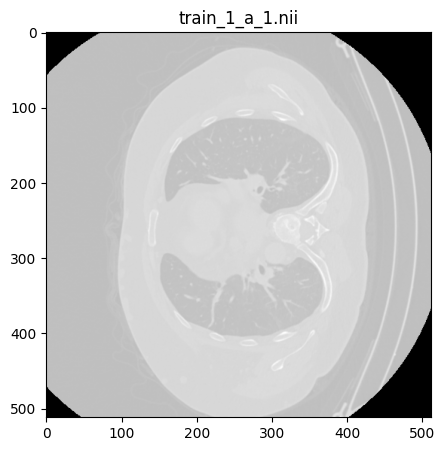

In [ ]:
mid_slice = img1.shape[2] // 2
slice1 = img1.get_fdata()[:, :, mid_slice]

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.imshow(slice1, cmap='gray')
axes.set_title("train_1_a_1.nii")
plt.show()

CT intensity (Used this to get an idea of the lung and bone thesholds)

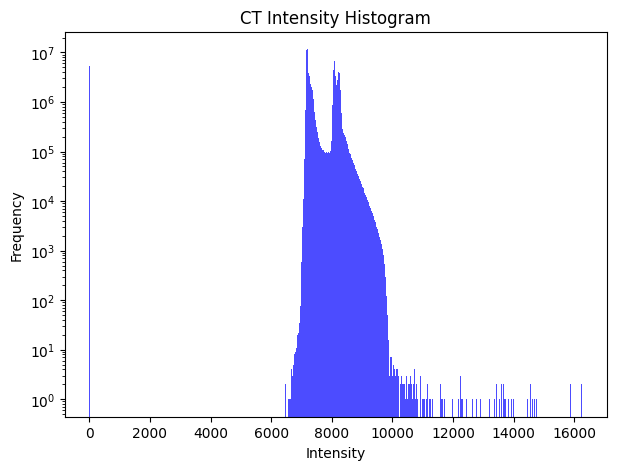

In [ ]:
plt.figure(figsize=(7, 5))
plt.hist(data.flatten(), bins=500, color='blue', alpha=0.7)
plt.yscale("log")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.title("CT Intensity Histogram")
plt.show()

In [ ]:
print("Min:", np.min(data), "Max:", np.max(data))

Min: 0.0 Max: 16270.0


## Getting the thresholds

Bone Theshold

In [ ]:
bone_lower = np.percentile(data, 99)
bone_upper = np.percentile(data, 100)
print("Bone Threshold:", bone_lower, bone_upper)

lungs = np.logical_and(data >= bone_lower, data <= bone_upper)

Bone Threshold: 8572.0 16270.0


In [ ]:
lung_lower = np.percentile(data, 48)
lung_upper = np.percentile(data, 60)
print("Lung Threshold:", lung_lower, lung_upper)

lungs = np.logical_and(data >= lung_lower, data <= lung_upper)

Lung Threshold: 7316.0 8039.0


Lung cleaning function

In [ ]:
def clean_lungs_mask(mask):
    labeled_mask = label(mask, connectivity=3)  # Separates the whole mask into diffeent components based on connectivity.
    component_sizes = np.bincount(labeled_mask.ravel())
    largest_labels = np.argsort(component_sizes)[-2:-1]  # keeps only the largest component. (excluding the background)
    final_mask = np.isin(labeled_mask, largest_labels)

    # Need to add code to remove extra noise below the lungs

    return final_mask

## Creating Masks (Lungs and bones)

In [ ]:
# Setting the threshold values for the lungs and bones
lung_threshold = (lung_lower, lung_upper)
bone_threshold = (bone_lower, bone_upper)

# Apply the theshold values to the data to create masks
lungs = np.logical_and(data >= lung_threshold[0], data <= lung_threshold[1])
bones = np.logical_and(data >= bone_threshold[0], data <= bone_threshold[1])

clean_lungs = clean_lungs_mask(lungs)

Visualize middle slice of masks

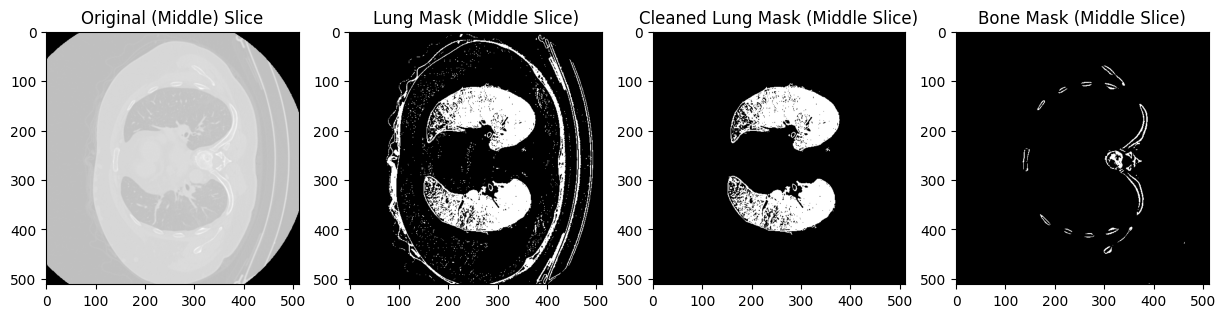

In [ ]:
# get the middle slices
lung_mask = lungs.astype(np.uint8) * 255
clean_lung_mask = clean_lungs.astype(np.uint8) * 255
bone_mask = bones.astype(np.uint8) * 255

# Visualize middle side by side

# The original middle slice with no mask applied to it.
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].imshow(data[:, :, mid_slice], cmap="gray")
ax[0].set_title("Original (Middle) Slice")

# The Lung mask present before cleaning
ax[1].imshow(lung_mask[:, :, mid_slice], cmap="gray")
ax[1].set_title("Lung Mask (Middle Slice)")

# Lung mask after cleaning
ax[2].imshow(clean_lung_mask[:, :, mid_slice], cmap="gray")
ax[2].set_title("Cleaned Lung Mask (Middle Slice)")

# The bone Mask (No cleaning done on it yet, will do later if requied)
ax[3].imshow(bone_mask[:, :, mid_slice], cmap="gray")
ax[3].set_title("Bone Mask (Middle Slice)")

plt.show()

## Visualize 3D model

Creating meshes using the masks

In [ ]:
def create_mesh(mask, threshold=0.5):
    verts, faces, _, _ = measure.marching_cubes(mask, level=threshold)
    return verts, faces

# Create the meshes for the lungs and bones
lung_verts, lung_faces = create_mesh(clean_lung_mask)
bone_verts, bone_faces = create_mesh(bone_mask)

Plot the 3D model

In [ ]:
# Initialize the visualization
fig = go.Figure()

# Plot the lungs with Translucent blue (comment this part out to see only the bones)
fig.add_trace(go.Mesh3d(
    x=lung_verts[:, 0], y=lung_verts[:, 1], z=lung_verts[:, 2],
    i=lung_faces[:, 0], j=lung_faces[:, 1], k=lung_faces[:, 2],
    color='rgba(51, 153, 255, 0.2)',  # blue
    name="Lungs"
))

# Plot the bones with opaque white (comment this part out to see only the lungs)
# fig.add_trace(go.Mesh3d(
#     x=bone_verts[:, 0], y=bone_verts[:, 1], z=bone_verts[:, 2],
#     i=bone_faces[:, 0], j=bone_faces[:, 1], k=bone_faces[:, 2],
#     color='rgba(230, 230, 230, 1.0)',  # white
#     name="Bones"
# ))


fig.update_layout(
    title="3D Model: Lungs (Blue) and Bones (White)",
    scene=dict(
        xaxis_title="X (mm)",
        yaxis_title="Y (mm)",
        zaxis_title="Z (mm)",
    ),
    showlegend=True
)

fig.show()

Output hidden; open in https://colab.research.google.com to view.